In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.ops import array_ops

from tfshow import show_graph
from emp_risk_optimizer import LinearRegression2Blocks

## Derivation for Linear Regression
Suppose $x^{1\times p}, X^{n\times p}, y^{n\times 1}$.
$$
\begin{split}
R_{emp} = \frac{1}{n}(y-X\beta)^{\top} (y-X\beta) \qquad&(1\times 1)\\
\nabla^2_{\beta}R_{emp} = \frac{2}{n}X^{\top}X \qquad&(p\times p)
\end{split}
$$
For some fixed validation or training point $z = (x,y)$
$$
\begin{split}
L(z;\hat{\beta}) = (y-x\hat{\beta})^{\top} (y-x\hat{\beta}) \qquad&(1\times 1)\\
\nabla_{\beta}L(z;\hat{\beta}) = -2x^{\top} (y-x\hat{\beta})\qquad&(p\times 1)\\
p = (\nabla^2_{\beta}R_{emp})^{-1}\nabla_{\beta}L(z_{te};\hat{\beta})\qquad&(p\times 1), \text{ Hessian-vector product}\\
u := \nabla_{\beta}L(z_{tr})=-2x_{tr}^{\top}(y_{tr}-x_{tr}\hat{\beta}) \qquad&(1\times p), \text{ Gradient of loss of 1 training point}\\
\mathcal{I}_{loss}(\color{red}{z_{tr}}, \color{blue}{z_{te}}) = u^{\top}p = 2n\color{red}{(y_{tr}-x_{tr}\hat{\beta})^{\top}x_{tr}}(X^{\top}X)^{-1}\color{blue}{x_{te}^{\top}(y_{te}-x_{te}\hat{\beta})}\qquad&(1\times 1)
\end{split}
$$

In [3]:
df = pd.read_csv('data/lm_10.csv')
n = len(df)
X = df.values[:, 0:10]
y = df.values[:, -1].reshape(n, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)
n, p = X_train.shape

(80, 10)
(20, 10)
(80, 1)
(20, 1)


## Theoretical Calculation

In [4]:
def I_loss_closed_form(X_tr, Y_tr, X_te, Y_te):
    n_tr, p = X_tr.shape
    n_te, _ = X_te.shape
    beta_hat = np.linalg.inv(
        X_tr.T.dot(X_tr)).dot(X_tr.T).dot(Y_tr)
    H_inv = (n_tr/2)*np.linalg.inv((X_tr.T.dot(X_tr)))
    I_loss = np.zeros((n_tr, n_te))
    for i in range(n_tr):
        for j in range(n_te):
            x_tr, y_tr = X_tr[i:i+1,:], Y_tr[i:i+1,:]
            x_te, y_te = X_te[j:j+1,:], Y_te[j:j+1,:]
            grad_tr = -2*x_tr.T.dot(y_tr - x_tr.dot(beta_hat))
            grad_te = -2*x_te.T.dot(y_te - x_te.dot(beta_hat))
            I_loss[i,j] = grad_tr.T.dot(H_inv).dot(grad_te)
    return I_loss

I_loss_cf = I_loss_closed_form(X_train, y_train, X_test, y_test)

## Test the Model

In [13]:
model = LinearRegression2Blocks(
    model_name='LinearRegression2Blocks',
    eta=0.01)
model.fit(X_train, y_train, n_iter=1000)

show_graph(tf.get_default_graph())

Step 0: loss = 151.12817383 (0.030 sec)


In [14]:
%%time
I_loss_bf = model.influence_loss(
    X_test, y_test, method='brute-force')

Fetch training loss gradients (0.084 sec)
CPU times: user 236 ms, sys: 15.1 ms, total: 251 ms
Wall time: 231 ms


In [7]:
abs_pct_error = 100*np.abs(
    I_loss_bf - I_loss_cf) / np.abs(I_loss_cf)
print("Absolute percentage error to closed form:")
for row in abs_pct_error:
    print([('%.3f' % x) + '%' for x in row])

Absolute percentage error to closed form:
['0.074%', '0.048%', '0.046%', '11.697%', '0.108%', '0.303%', '0.069%', '0.377%', '0.324%', '0.059%', '0.022%', '0.204%', '0.071%', '0.008%', '0.012%', '0.066%', '0.083%', '0.276%', '0.079%', '0.003%']
['0.016%', '0.139%', '0.044%', '11.618%', '0.018%', '0.213%', '0.022%', '0.467%', '0.414%', '0.031%', '0.112%', '0.114%', '0.019%', '0.082%', '0.079%', '0.024%', '0.008%', '0.186%', '0.011%', '0.093%']
['0.026%', '0.097%', '0.002%', '11.655%', '0.060%', '0.260%', '0.020%', '0.425%', '0.372%', '0.011%', '0.070%', '0.156%', '0.022%', '0.040%', '0.037%', '0.018%', '0.035%', '0.228%', '0.031%', '0.051%']
['0.257%', '0.380%', '0.286%', '11.404%', '0.223%', '0.028%', '0.263%', '0.710%', '0.657%', '0.273%', '0.354%', '0.127%', '0.260%', '0.324%', '0.320%', '0.266%', '0.249%', '0.054%', '0.252%', '0.335%']
['0.062%', '0.061%', '0.033%', '11.686%', '0.096%', '0.291%', '0.057%', '0.389%', '0.336%', '0.046%', '0.035%', '0.192%', '0.059%', '0.004%', '0.001%'

## Test Against LOO

In [15]:
%%time
I_loss_loo = model.leave_one_out_refit(
    X_test, y_test, n_iter=1000)

LOO Fold 0: loss = 1.14274800 (0.571 sec)
LOO Fold 8: loss = 1.14815354 (0.600 sec)
LOO Fold 16: loss = 1.14723504 (0.490 sec)
LOO Fold 24: loss = 1.08481216 (0.528 sec)
LOO Fold 32: loss = 1.14790761 (0.568 sec)
LOO Fold 40: loss = 1.14130855 (0.485 sec)
LOO Fold 48: loss = 1.14709246 (0.544 sec)
LOO Fold 56: loss = 1.13606179 (0.593 sec)
LOO Fold 64: loss = 1.14732301 (0.556 sec)
LOO Fold 72: loss = 1.12661207 (0.534 sec)
CPU times: user 58.4 s, sys: 7.66 s, total: 1min 6s
Wall time: 44 s


In [16]:
def LOO_closed_form(X_tr, Y_tr, X_te, Y_te):
    l2_loss = lambda x,y,b: (y-x.dot(b))**2
    n_tr, p = X_tr.shape
    n_te, _ = X_te.shape
    beta_hat = np.linalg.inv(
        X_tr.T.dot(X_tr)).dot(X_tr.T).dot(Y_tr)
    L_full = l2_loss(X_te, Y_te, beta_hat)
    loss_diff = np.zeros((n_tr, n_te))
    for i in range(n_tr):
        rest_indices = [idx for idx in range(n_tr) if idx!=i]
        X_loo, Y_loo = X_tr[rest_indices, :], Y_tr[rest_indices, :]
        beta_loo = np.linalg.inv(
            X_loo.T.dot(X_loo)).dot(X_loo.T).dot(Y_loo)
        L_loo = l2_loss(X_te, Y_te, beta_loo)
        loss_diff[i, :] = (L_full - L_loo).T
    return loss_diff

# closed form loo loss difference
loo_loss_cf = LOO_closed_form(X_train, y_train, X_test, y_test)

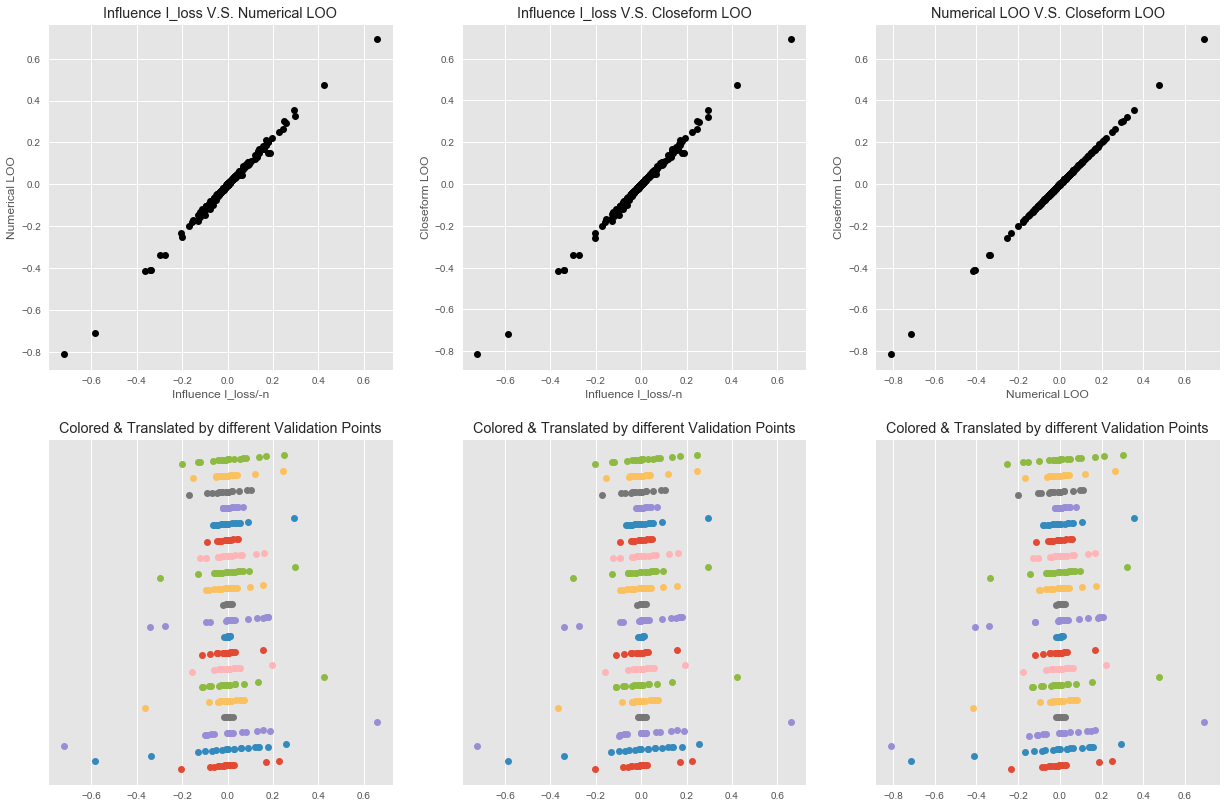

In [17]:
fig, axes = plt.subplots(2, 3 ,figsize=(21,14))
n_tr, _ = X_train.shape
n_te, _ = X_test.shape

for j in range(n_te):
    axes[0,0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:], 
                 'o', color='black')
    axes[0,1].plot(I_loss_bf[j,:]/(-n_tr), loo_loss_cf[j,:], 
                 'o', color='black')
    axes[0,2].plot(I_loss_loo[j,:], loo_loss_cf[j,:], 
                 'o', color='black')
    
    axes[1,0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:]+j, 'o')
    axes[1,1].plot(I_loss_bf[j,:]/(-n_tr), loo_loss_cf[j,:]+j, 'o')
    axes[1,2].plot(I_loss_loo[j,:], loo_loss_cf[j,:]+j, 'o')

axes[0,0].update({
    'title':'Influence I_loss V.S. Numerical LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Numerical LOO'})
axes[0,1].update({
    'title':'Influence I_loss V.S. Closeform LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Closeform LOO'})
axes[0,2].update({
    'title':'Numerical LOO V.S. Closeform LOO',
    'xlabel': 'Numerical LOO',
    'ylabel': 'Closeform LOO'})
axes[1,0].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
axes[1,1].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
_ = axes[1,2].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})